In [1]:
#| default_exp exposure
%reload_ext autoreload
%autoreload 2
from nbdev.showdoc import show_doc
import matplotlib.pyplot as plt
# plt.rc('figure',facecolor='white')
!date

Fri Mar  3 00:12:19 PST 2023


The spacecraft information is a list, for 30-s intervals, of the livetime and instrument $\theta$ of the source. 
We need a weighted effective area
as a function of $\theta$. This requires a weighting function of energy, or a spectrum. Matthew used a simple power law with index -2.1. implemented in by the class `KerrAeff`. But here we have the actual source spectrum available. Also, the data here excludes low-energy Back events the class `SourceAeff` uses both.

## Implemented here:

* `time_bin_edges`
* `cell_exposure`
* `sc_data_selection`
* `binned_exposure`


In [2]:
#| export
import pandas as pd
import numpy as np

from wtlike.config import (Config, UTC, MJD)
from wtlike.effective_area import EffectiveArea

In [3]:
#| export  
def time_bin_edges(config, exposure, tbin=None):
    """Return an interleaved array of start/stop values

    tbin: an array (a,b,d), default config.time_bins

    interpretation of a, b:

        if > 50000: interpret as MJD
        if < 0:     offset from stop
        otherwise:  offset from start

    d : if positive, the day bin size
        if 0; return contiguous bins


    """
    # nominal total range, MJD edges
    tstart = start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])

    a, b, step = tbin if tbin is not None else config.time_bins


    if a>50000: start=a
    elif a<0: start = stop+a
    else : start = tstart + a

    if b>50000: stop=b
    elif b>0: stop = tstart+b
    else: stop += b

    if step<=0:
        return contiguous_bins(exposure.query(f'{start}<start<{stop}'),)

    # adjust stop
    nbins = int((stop-start)/step)
    assert nbins>0, 'Bad binning: no bins'
    stop = start+(nbins)*step
    u =  np.linspace(start,stop, nbins+1 )

    # make an interleaved start/stop array
    v = np.empty(2*nbins, float)
    v[0::2] = u[:-1]
    v[1::2] = u[1:]
    return v

In [4]:
show_doc(time_bin_edges)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/exposure.py#L15){target="_blank" style="float:right; font-size:smaller"}

### time_bin_edges

>      time_bin_edges (config, exposure, tbin=None)

Return an interleaved array of start/stop values

tbin: an array (a,b,d), default config.time_bins

interpretation of a, b:

    if > 50000: interpret as MJD
    if < 0:     offset from stop
    otherwise:  offset from start

d : if positive, the day bin size
    if 0; return contiguous bins

In [5]:
#| export
def cell_exposure(config, exposure, time_bins, exposure_factor=1e-6, set_costh=False):
    """
    Determine the exposure per cell
    input:
    - exposure -- dataframe with spacecraft data
    - time_bins -- time binning (start, stop, step) tuple

    Return: a dict of
    - edges -- list of cell edges, an interleaved array of start/stop values
    - exp -- exposure per cell, in cm^2 Ms units, if exposure_factor==1e-6
    - etot -- total exposure
    - costh -- mean cos theta per cell if requested
    - exp_energy if exp_fract in the exposure DF, set exposure energy

    Note: total exposure vs. energy is:
        t = df.apply(lambda r: np.array(r.exp * np.array(r.exp_fract), float), axis=1).values
        u = np.vstack(t)
    """
    exp = exposure.exp.values

    etot = np.sum(exp) * exposure_factor

    cell_edges = time_bin_edges(config, exposure, time_bins)
    # the cell index list
    eci = np.searchsorted(exposure.stop, cell_edges).reshape(len(cell_edges)//2,2)
    cell_exp = np.array([exp[slice(*ecx)].sum()*exposure_factor for ecx in eci], np.float32) #np.float32)

    ret = dict(exp=cell_exp, edges=cell_edges, etot=etot)

    if set_costh:
        costh = exposure.cos_theta.values
        ret['costh'] =np.array([costh[slice(*ecx)].mean() for ecx in eci], np.float32)


    ef = exposure.get('exp_fract', None)
    if ef is not None:
        efa = np.array([np.array(x,float) for x in ef])
        efe = efa.T * exp
        ret['exp_energy'] = np.array([efe.T[slice(*ecx)].sum(axis=0)*exposure_factor for ecx in eci], np.float32)

    return ret

In [6]:
show_doc(cell_exposure)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/exposure.py#L62){target="_blank" style="float:right; font-size:smaller"}

### cell_exposure

>      cell_exposure (config, exposure, time_bins, exposure_factor=1e-06,
>                     set_costh=False)

Determine the exposure per cell
input:
- exposure -- dataframe with spacecraft data
- time_bins -- time binning (start, stop, step) tuple

Return: a dict of
- edges -- list of cell edges, an interleaved array of start/stop values
- exp -- exposure per cell, in cm^2 Ms units, if exposure_factor==1e-6
- etot -- total exposure
- costh -- mean cos theta per cell if requested
- exp_energy if exp_fract in the exposure DF, set exposure energy

Note: total exposure vs. energy is:
    t = df.apply(lambda r: np.array(r.exp * np.array(r.exp_fract), float), axis=1).values
    u = np.vstack(t)

In [7]:
#| exporti
def sc_process(config, source, sc_data):

    """
    - source -- contains ra, dec in degrees
    - sc_data -- DF constructed from spacecraft data (FT2).

    Return: a dict with the S/C data for the source direction, wtih cos theta and zenith cuts

    columns:
    - start, stop, livetime -- from the FT2 info
    - cos_theta -- angle between bore and direction
    """

    # calculate cosines with respect to sky direction
    ra_r,dec_r = np.radians(source.ra), np.radians(source.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    cos_thetas = cosines(sc_data.ra_scz,    sc_data.dec_scz)
    zcosines = cosines(sc_data.ra_zenith, sc_data.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (cos_thetas >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = sc_data.loc[mask,:]
    livetime = dfm.livetime.values

    return  pd.DataFrame(
        dict(
            start=sc_data.start[mask].astype(np.float64),
            stop=sc_data.stop[mask].astype(np.float64),
            livetime=livetime,
            cos_theta=cos_thetas[mask],
            )
         )

In [8]:
#| export
from scipy.integrate import simpson

def cumsimpson(y, dx):
    """Return the cumulative Simpson integral for an odd number>2 of equally-spaced evaluations
     * y -- array of integrand values, 2n+1 values for 2n intervals
     * dx -- interval size

     Returns array of size n, the cumulative integral estimate for pairs of intervals.

     >>> x, dx = np.linspace(0,1, 5), 1/4
     >>> print(cumsimpson(x, dx))
     >>> [0.125 0.5  ]
    """
    v = np.empty((3*(len(y)-1)//2))
    v[0::3] = y[0:-1:2]
    v[1::3] = 4*y[1::2]
    v[2::3] = y[2::2]
    return (np.cumsum(v)*dx/3)[2::3]

### Demonstrate superiority of integral using integrand  $x\ f(x)\  d\log(x)$

Instead of $f(x)\ dx$.

In [9]:
nbins = 16
f = lambda x: x**-2
ee = np.logspace(2,4,nbins+1)
r = 1e-2-1e-4
print(f'Errors:\n\tLinear: {simpson(f(ee), ee)/r-1:+6.1e}'
      f'\n\tLog:    {simpson( f(ee)*ee, np.log(ee) )/r-1:+6.1e}')

Errors:
	Linear: -4.7e-03
	Log:    +3.8e-05


In [10]:
#| include: false
x = np.linspace(0,1,5)
assert( np.all( cumsimpson(x, 1/4) == np.array([1/8,1/2]) ) ), 'Fail simple test'

In [11]:
#| export
from abc import abstractmethod

class BaseAeff(object):
    """
    Base class for calculating the weighted effective area

    It defines a functor of `costh`, returning  the effective area weighted by a spectrum.
    The exposure is then a sum over intervals of this weighted effective area times the livetime per interval.

    A subclass must define a `setup` method to define the spectral function and minimum energy
    to include Back events.
    """

    # default energies to use for Simpson's integral: 8/decade from 100 MeV to 10 GeV
    edom = np.logspace(2,4,17)

    def __init__(self, config, source,
                 elim:tuple=(1e2,1e4)):
        self.elim = elim
        self.source = source
        self.Aeff = EffectiveArea(file_path=config.datapath/'aeff_files')
        self.back_min =0 #??
        self.setup()

    @abstractmethod
    def setup(self):
        pass

    def __call__(self, cos_theta) : #sc_data):
        """
        Return the weighted effective area as a function of $\\cos( \\theta) $

        """
        # as set by self.setup -- also self.back_min
        edom = self.edom
        wts = self.wts
        cos_theta = np.atleast_1d(cos_theta)

        # a table of the weights for each pair in spectral flux and cos_theta arrays
        rvals = np.empty([len(wts),len(cos_theta)])

        for i, (en,wt) in enumerate(zip(edom,wts)):
            faeff, baeff = np.array(self.Aeff( [en], cos_theta ))
            rvals[i] =  faeff * wt if en<self.back_min else  (faeff+baeff) * wt

        from scipy.integrate import simpson
        aeff = simpson(rvals, edom,axis=0) / simpson(wts,edom)

        return aeff

class KerrAeff(BaseAeff):
    """
    Kerr implementation from godot, which uses a $E^{-2.1}$ powerlaw spectrum
    """

    bins_per_decade: int=10
    base_spectrum: str='lambda E: (E/1000)**-2.1'
    energy_range: tuple =(100,1e4)# (100.,1e6)

    def setup(self ):

        """set up energy domain, evaluate fluxes
           This is the Kerr version, using a powerlaw spectrum
        """

        emin,emax = self.energy_range
        loge1=np.log10(emin); loge2=np.log10(emax)
        self.edom= np.logspace(loge1, loge2, int((loge2-loge1)*self.bins_per_decade+1))

        spectrum = eval(self.base_spectrum) #lambda E: (E/1000)**-2.1

        self.wts = spectrum(self.edom) # * self.edom

        # the threshold for including Back events
        # should use default, this is what I was usinq
        self.back_min=0

class SourceAeff(BaseAeff):
    """
    BaseAeff subclass that uses the actual source spectrum applied only to used bands
    """

    def setup(self):
        f = self.source.spectral_model
        self.wts  = f(self.edom) #* self.edom
        self.back_min=10**2.5

In [12]:
#| export
class WeightedAeff():
    """Manage the weighted effective area calculation
    """

    def __init__(self, config=None,
                 spectrum = None,
                 nebins:int=16,
                 imin:tuple=(0,0),
                 **kwargs):
        """
        """
        config = config or Config()
        self.nebins = nebins
        self.imin = imin
        self.spectrum = spectrum or (lambda E: (E/1000)**-2.1)
        self.Aeff = EffectiveArea(file_path=config.datapath/'aeff_files')
        self.edom = np.logspace(2,4, self.nebins+1)
        self.logedom = np.log(self.edom)
        self.dx = dx = np.log(self.edom[-1]/self.edom[0])/self.nebins;
        self.wts  = self.spectrum(self.edom)
        self.xwts = self.wts*self.edom
        self.norm = simpson(self.xwts, dx=dx)

    def cumintegral(self, aeff, start=0):
        r = cumsimpson((aeff*self.xwts)[start:], dx=self.dx)/self.norm
        if start==0: return r
        return np.insert(r, 0, [0]*(start//2))

    def cumint(self, costh):
        costh = np.atleast_1d(costh)

        r = [ np.array([self.cumintegral( a, start)
                 for start,a in zip(
                     self.imin, np.array(self.Aeff(self.edom,  z))) ]).sum(axis=0)
             for z in costh]
        return  np.array(r)

    def __call__(self, costh):
        return self.cumint(costh)[:,-1]

    def binned(self, costh):
        """Split it into 8 bins    """
        costh = np.atleast_1d(costh)
        # costh = np.atleast_1d(costh)
        # r = [np.diff(np.insert(self.cumint(z),0,0)) for z in costh]
        # return np.array(r)
        return np.diff(np.insert(self.cumint(costh),0,0,axis=1))

    def beam_window(self, lmax=12):
        """ Return an array of Legendre coefficients
            Corresponds to a healpy "beam_window" function
        """

        import healpy
        func2 = lambda z : np.where( z>0.2, self(z), 0)
        lmax=12
        theta = np.linspace(0,np.pi,181)
        z = np.cos(theta)
        bl = healpy.sphtfunc.beam2bl(func2(z), theta, lmax=lmax);
        return bl

class NewSourceAeff(WeightedAeff):
    def __init__(self, config, source):
        super().__init__(config, spectrum=source.spectral_model, imin=(0,4),)


def weighted_aeff(config, source):

    """ Use config.use_kerr to return appropriate weighted effective area function of cos theta
    """

    # return KerrAeff(config, source) if config.use_kerr else SourceAeff(config, source)

    if config.use_kerr:
        return WeightedAeff(config)
    ### source spectrum, cut low back
    return WeightedAeff(config, spectrum=source.spectral_model, imin=(0,4))

In [13]:
#| include: false

from wtlike.sources import PointSource
config = Config(verbose=2)  
if config.valid:
    source = PointSource('Geminga', config=config)
    self = WeightedAeff(config)               
    assert round(self(1.0)[0],1)==5374.0, 'fail Effective area check'   
    cts = [0.9,1.0]
    assert( np.all(self.binned(cts).sum(axis=1)==self(cts))), 'fail Effective area check' 

WeightMan: file from source "PSR J0633+1746"_weights.pkl : 16 bamds with nsides 64 to 512


## Weighted exposure

The computation of the likelihood for a given cell needs a measurement of the exposure to determine the 
estimated number of source counts expected for the average source rate. 

In [14]:
show_doc(weighted_aeff)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/exposure.py#L319){target="_blank" style="float:right; font-size:smaller"}

### weighted_aeff

>      weighted_aeff (config, source)

Use config.use_kerr to return appropriate weighted effective area function of cos theta

## Compare weighted effective area: Kerr-mode vs actual with Geminga

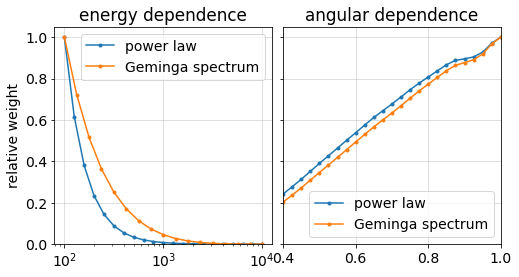

In [15]:
#| code-fold: true hide
from wtlike.sources import PointSource
config=Config()
# source_name='LS 5039' #'Geminga'

def aeffplots(ke,se):
    ct = np.linspace(0.4, 1.0, 25)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4), sharey=True)
    plt.subplots_adjust(wspace=0.05)
    ax1.semilogx(ke.edom, ke.wts/ke.wts[0], '.-', label='power law')
    ax1.semilogx(se.edom, se.wts/se.wts[0], '.-', label=f'{source_name} spectrum')
    ax1.legend();ax1.grid(alpha=0.5)
    ax1.set(title='energy dependence', ylabel='relative weight')

    ax2.plot(ct, se(ct)/se(1), '.-', label='power law')
    ax2.plot(ct, ke(ct)/ke(1), '.-', label=f'{source_name} spectrum')
    ax2.set( title='angular dependence',xlim=(0.4,1.0), ylim=(0, None),)
    ax2.grid(alpha=0.5); ax2.legend();

if config.valid:
    source_name='Geminga'
    source=PointSource(source_name)

    ke = KerrAeff(config, source) 
    se = SourceAeff(config, source)
    aeffplots(ke,se)

## Effective area vs energy band

Compare the Kerr power-law spectrum with that for Geminga.
The latter removes back photons below 316 MeV.
<div style="margin-left: 25px"><figure style="margin-left: 25px" title="Figure 1">   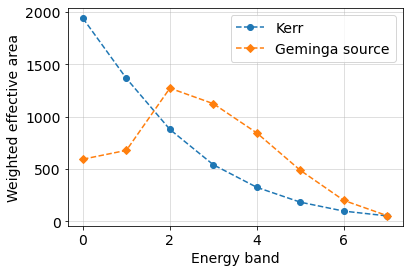 </figure></div>


In [16]:
#| include: false
from utilities.ipynb_docgen import *
@ipynb_doc
def aeff_vs_band():
    """
    ## Effective area vs energy band
    
    Compare the Kerr power-law spectrum with that for Geminga.
    The latter removes back photons below 316 MeV.
    {fig}
    """
    plt.rc('font', size=14)
    # plt.rc('figure', facecolor='white')
    ke2 = WeightedAeff(config)
    se2=NewSourceAeff(config, source)

    fig, ax = plt.subplots()
    ax.plot(ke2.binned(1)[0], 'o--', label='Kerr')
    ax.plot(se2.binned(1)[0], 'D--', label='Geminga source')
    ax.set(xlabel='Energy band', ylabel='Weighted effective area')
    ax.legend();ax.grid(alpha=0.5);
    return locals()
if config.valid:
    aeff_vs_band()

In [17]:
#| export
def sc_data_selection(config, source, sc_data):

    """
    Return a DataFrame with the S/C data for the source direction, wtih cos theta and zenith cuts

    columns:
    - start, stop, livetime -- from the FT2 info
    - cos_theta -- angle between bore and direction
    - exp -- the exposure: effective area at angle weighted by a default spectral function, times livetime

    """

    sc_df = sc_process(config, source, sc_data)
    cos_theta = sc_df.cos_theta.values
    livetime = sc_df.livetime.values

    # now get appropriate weighted effective area, multipy by livetime
    if len(cos_theta)>0:
        if config.use_kerr:
            sc_df.loc[:,'exp'] = KerrAeff(config, source)(cos_theta) * livetime
        else:
            sc_df.loc[:,'exp'] = SourceAeff(config, source)(cos_theta) * livetime

    return sc_df

In [18]:
#| export
def binned_exposure(config, exposure, time_edges):
    """Bin the exposure into cells

    - exposure -- A DataFrame derived from FT2
    - time_bins: list of edges, an interleaved start/stop array


    Returns:

    An array of exposure integrated over each time bin. Assumes that the time bins
    are contained within the exposure.

    it is interleaved, client must apply [0::2] selection.

    """

    # get exposure calculation
    exp   =exposure.exp.values
    estart= exposure.start.values
    estop = exposure.stop.values

    # determine bins,

    #use cumulative exposure to integrate over larger periods
    cumexp = np.concatenate(([0],np.cumsum(exp)) )

    # get index into tstop array of the bin edges
    edge_index = np.searchsorted(estop, time_edges)

    # return the exposure integrated over the intervals
    cum = cumexp[edge_index]

    # difference is exposure per interval
    bexp = np.diff(cum)
#     if config.verbose>1:
#         print(f'exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
    return bexp

In [19]:
show_doc(binned_exposure)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/exposure.py#L358){target="_blank" style="float:right; font-size:smaller"}

### binned_exposure

>      binned_exposure (config, exposure, time_edges)

Bin the exposure into cells

- exposure -- A DataFrame derived from FT2
- time_bins: list of edges, an interleaved start/stop array

Returns:

An array of exposure integrated over each time bin. Assumes that the time bins
are contained within the exposure.

it is interleaved, client must apply [0::2] selection.

In [20]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Fri Mar  3 00:12:28 PST 2023
